# Find a plane Couette equilibrium with CloudAtlas.jl

2025-10-29. Produce data for ODE convergence plot for PRL  
2025-11-03. Revised to work with CloudAtlas package  
2025-11-11. Removed dependence on data files

  1. Construct an low-d ODE model for a symmetric subspace of plane Couette flow, 
  using Galerkin projection onto finite basis that incorporates the 
  boundary conditions & incompressibility constraint and spans a specified symmetric
  subspace of the flow. 
  2. Search for an equilibrium in the ODE. Use the projection of the Nagata
upper-equilibrium onto the basis for the initial guess.
  3. Compute the eigenvalues of the ODE equilibrium and compare to those from DNS.

## 0. Preliminaries

Load some packages and define a few functions. 

In [1]:
using LinearAlgebra, Polynomials, Plots
using Revise, DelimitedFiles, BenchmarkTools

using CloudAtlas

display("text/html", "<style>.container { width:100% !important; }</style>")

"""
    myreaddlm(filename, cc='%')

Read matrix or vector from a file, dropping comments marked with cc.
"""
function myreaddlm(filename, cc='%')
    X = readdlm(filename, comments=true, comment_char=cc)
    if size(X,2) == 1
        X = X[:,1]
    end
    X
end

# handy symmetry definitions
id = Symmetry()
sx = Symmetry(-1,1,1)
sy = Symmetry(1,-1,1)
sz = Symmetry(1,1,-1)
tx = Symmetry(1,1,1, 1//2, 0//1)
tz = Symmetry(1,1,1, 0//1, 1//2)

pwd()

"/home/gibson/gitworking/CloudAtlas/notebooks"

## 1. Construct an ODE model of plane Couette flow

Construct a set of divergence-free, periodic/no-slip basis functions $\bf{\Psi}$
for expanding a velocity field, ${\bf u}({\bf x},t) = \sum_{i=1^m} x_i(t) {\bf \Psi}({\bf x})$.
Here ${\bf u}$ is the fluctuating velocity; the total velocity field is the sum of laminar
flow and the fluctuation, ${\bf u}_{tot}({\bf x},t) = y \, {\bf e}_x + {\bf u}({\bf x},t)$.

Then construct ODE model of plane Couette flow $B dx/dt = (A_1 + R^{-1} A_2) x + N(x)$ where
$B, A_1, A_2,$ and $N$ are determined by Galerkin projection of the plane Couette 
Navier-Stokes equations onto the basis. $A_1$ represents the The return values of `ODEModel` are functions
$f(x,R) = B^{-1} (A_1 + R^{-1} A_2) x + N(x)$ and $Df(x,R) = [\partial f_i/\partial x_j]$

In [2]:
α, γ = 1.0, 2.0                     # Fourier wavenumbers α, γ = 2π/Lx, 2π/Lz
J,K,L = 1,1,3                       # Bounds on Fourier modes (J,K) and wall-normal polynomials (L)

H = [sx*sy*sz, sz*tx*tz]            # Generators of the symmetric subspace of the Nagata eqb

@time ijkl = basisIndices(J,K,L, H) # Compute index set of H-symmetric basis elements Ψijkl
@time Ψ = basisSet(α, γ, ijkl)      # Compute basis elements Ψijkl in the index set
@time model = ODEModel(Ψ);          # Do Galerkin projection, return struct w function f(x,R) for ODE dx/dt = f(x,R)

@show Nmodes = length(Ψ)

  0.856864 seconds (1.51 M allocations: 71.388 MiB, 2.76% gc time, 99.99% compilation time)
  2.282456 seconds (3.82 M allocations: 186.122 MiB, 2.19% gc time, 99.93% compilation time)
Making matrices B,A1,A2,S3...
Making quadratic operator N...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
  1.474858 seconds (1.29 M allocations: 62.800 MiB, 98.22% compilation time)
Nmodes = length(Ψ) = 17


17

Look at the first few basis functions. 

In [3]:
for n in 1:5
    println("Ψ$(ijkl[n,:]) = $(psistr(Ψ[n]))")
end

Ψ[1, 0, 0, 1] = [  (+1) (+1) (+1) (-4.0*y + 4.0*y^3)) ; 0 ; 0 ]
Ψ[1, 0, 0, 3] = [  (+1) (+1) (+1) (5.0*y - 14.0*y^3 + 9.0*y^5)) ; 0 ; 0 ]
Ψ[1, 0, 1, 0] = [  (+1) (+1) (+1) sin(γz) (1.0 - 1.0*y^2)) ; 0 ; 0 ]
Ψ[1, 0, 1, 2] = [  (+1) (+1) (+1) sin(γz) (1.0 - 6.0*y^2 + 5.0*y^4)) ; 0 ; 0 ]
Ψ[2, 0, 1, 1] = [  0 ; (2.0) (+1) (+1) sin(γz) (1.0 - 2.0*y^2 + 1.0*y^4)) ; (+1) (+1) (+1) cos(γz) (-4.0*y + 4.0*y^3)) ]


Verify that $x=0$ is a solution (the laminar solution) of $f(x,R)$ by showing 
$\|f(0,400)\| = 0$.

In [4]:
x = zeros(Nmodes)
norm(model.f(x, 400))

0.0

## Solve for eqb using hookstep

Use a precomputed initial guess for the equilibrium solution. This guess was obtained from
projecting the Nagata solution at $L_x,L_z = 2\pi,pi$, $Re=200$ onto the $J,K,L = 1,1,3$ basis
for the $\langle \sigma_{xyz}, \tau_{xz} \rangle$ subspace using the channelflow `projectfield`
utility. 

```bash
projectfield ijkl-sxyz-sztxz-1-1-3-17d.asc EQ2Re200-48x49x48.nc eq2re200-1-1-3
```

where `ijkl-sxyz-sztxz-1-1-3-17d.asc` is a file specifying the $i,j,k,l$ indices for the 
basis set, `EQ2Re200-48x49x48.nc` is a NetCDF file containing a channelflow FlowField,
and `eq2re200-1-1-3` is a filename stub for the output file containing the 17 components
of the projection, which we will use for the initial guess.

Here we just hardcode the value of this `xguess`.

In [5]:
xguess =  [0.105, -0.0539, 0.388, -0.0172, -0.0133, 0.0113, -0.00706, 0.0240, -0.0344, 
        -0.00868, -0.01264, -0.0234, -0.0320, -0.0180, -0.00464, 0.0106, 0.0235]

17-element Vector{Float64}:
  0.105
 -0.0539
  0.388
 -0.0172
 -0.0133
  0.0113
 -0.00706
  0.024
 -0.0344
 -0.00868
 -0.01264
 -0.0234
 -0.032
 -0.018
 -0.00464
  0.0106
  0.0235

Load the data file into channel flow. EQ2 is the Nagata upper-branch equilibrium.

Newton-hookstep search for equilibrium solution of the ODE $dx/dt = f(x)$ using EQ2 projection as initial guess.

In [7]:
R = 200.0
fᵣ = x -> model.f(x,R)    # define function fᵣ(x) = f(x,R)   for fixed R
Dfᵣ = x -> model.Df(x,R)  # define function Dfᵣ(x) = Df(x,R) for fixed R

hookparams = SearchParams(ftol=1e-08, xtol=1e-12, Nnewton=30,Nhook=8,verbosity=0)
@time xsoln, success = hookstepsolve(fᵣ, Dfᵣ, xguess)

@show norm(fᵣ(xsoln))/norm(xsoln)
@show norm(xsoln)
@show success;

  1.724726 seconds (1.51 M allocations: 74.834 MiB, 1.00% gc time, 98.50% compilation time)
norm(fᵣ(xsoln)) / norm(xsoln) = 2.8383128391306063e-11
norm(xsoln) = 0.5383294865167708
success = true


In [8]:
xsoln

17-element Vector{Float64}:
  0.1676450128736397
 -0.018552429250744684
  0.4864080002902331
 -0.09759477645308458
 -0.03411986463458746
 -0.010665050861812839
 -0.017317132746963327
  0.020113317514973517
 -0.03572908824630487
 -0.008809478655006359
 -0.01843173468129687
 -0.0473648253072869
 -0.04609045287291713
 -0.03157916691187481
  0.0010374375633457641
  0.01601957684818248
  0.07702704664092128

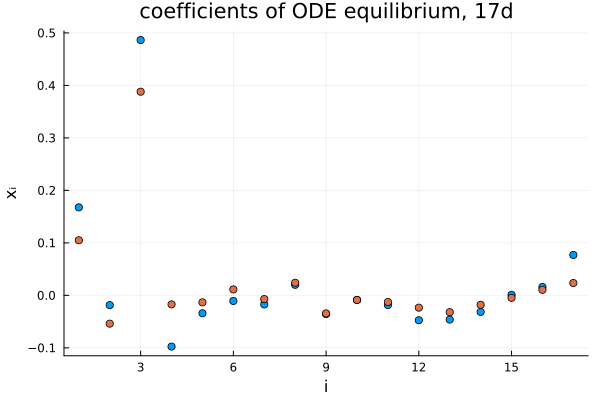

In [9]:
using Plots

scatter(1:Nmodes, xsoln, label="x solution")
scatter!(1:Nmodes, xguess, label="x guess")
plot!(xlabel="i", ylabel="xᵢ", legend=:none, title="coefficients of ODE equilibrium, $(Nmodes)d")

The likeness of ODE equilibrium (x solution) to projection of the Nagata solution
(x guess) means these two points are nearby in the low-d symmetric subspace.
The ODE equilibrium represents a rough force balance among the fundamental 
Fourier-polynomial modes very similar to the same modes in a highly-resolved
DNS computation. 

### Eigenvalues 

Compute the eigenvalues of the ODE equilibrium. The DNS eqb has just one real unstable eigenvalue.
With such a crude discretization, the ODE eigenvalues are quite different.

In [23]:
@time λODE = sort(eigvals(Dfᵣ(xsoln)), by = λ -> real(λ), rev=:true)
λODE[1:10]

  0.674610 seconds (385.73 k allocations: 19.316 MiB, 98.07% compilation time)


10-element Vector{ComplexF64}:
  0.09395778500039925 - 0.16380273528182915im
  0.09395778500039925 + 0.16380273528182915im
  0.04460084138110809 + 0.0im
   0.0241205226306713 - 0.5786157603258668im
   0.0241205226306713 + 0.5786157603258668im
 -0.05122501325805808 + 0.0im
 -0.13041119073634416 - 0.17266433717155003im
 -0.13041119073634416 + 0.17266433717155003im
 -0.16183109503043597 - 0.30833133428799325im
 -0.16183109503043597 + 0.30833133428799325im

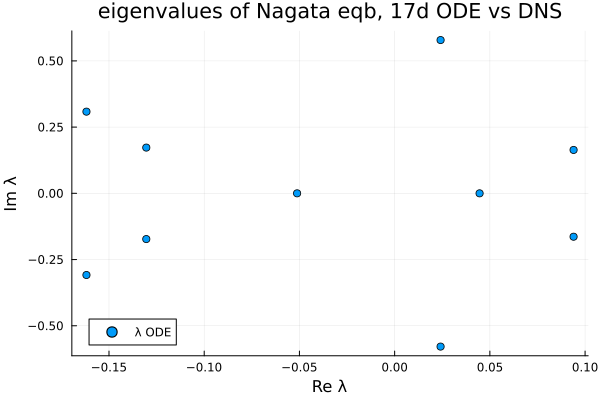

In [27]:
n=10
scatter(λODE[1:n], markersize=4, markershape=:circle, label="λ ODE")
plot!(xlabel = "Re λ", ylabel="Im λ", legend=:bottomleft)
plot!(title="eigenvalues of Nagata eqb, $(Nmodes)d ODE vs DNS")